# Recurrent Neural Network
From DNN to RNN:    
Whereas DNN accepts one input at a time, RNN accepts streaming input.
RNNs are well-suited for sequences, time series, and natural language processing (NLP).
However, since 2019, RNNs have been surpassed at NLP by Transformer models
such as BERT, Alberta, and Roberta.

RNN, LSTM, GRU:    
The RNN invention is usually attributed to Rumelhart,
though the older Hopfield Network is similar.
The vanilla RNN suffers from memory decay that is exponential over time.
Variants with longer memories are called long-short-term memory (LSTM) and 
gated-recurrent units (GRU). 

Similarity of DNN, CNN, RNN:    
The DNN, being fully connected, suffers from parameter explosion.
The CNN reduces parameters using convolutions that each apply a small set of parameters to every subregion of the image.
The RNN reduces parameters using recurrences that each apply a small set of parameters to every subregion of the input sequence.

Acknowledgement:   
This notebook is a modification of my DenseNeuralNetwork notebook.
I used help from Jason Brownlee's tutorials on  
[time series](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Architecture
Layers:    

Recurrent neurons or units:   

## Training and Evaluation
Training and evaluating the model works identically for RNN as for DNN.
Please see my notes on the DenseNeuralNetwork notebook.

In [1]:
import datetime
print(datetime.datetime.now())
from platform import python_version
print('Python',python_version())
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

2022-09-06 15:53:05.336996
Python 3.10.0


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import StratifiedKFold

## The Dataset
Airline Passengers:   
We'll use Jason Brownlee's airline passengers dataset,
which merely provides total passengers per month over one decade.

In [3]:
# This fails for me due to an https cert issue.
# data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
# Instead, please run this command outside of the notebook.
# wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
data = pd.read_csv('airline-passengers.csv')
data

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


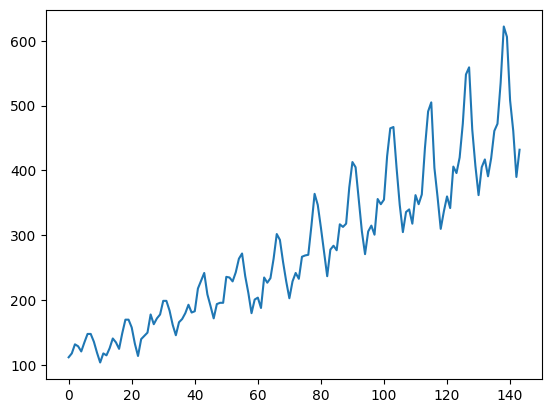

In [4]:
plt.plot(data['Passengers'])
plt.show()
# In a real experiment, we would not peek ahead at the test data!

### Normalization
Without normalization, pixel values range from 104 to 625.
This is a problem if low-range jumps (like 100 to 200)
seem huge compared to high-range jumps (like 500 to 600).
We simply shift all numbers to the (0,1) range.
Do this to the train and test sets.
When making predictions, we must unshift the values.

In [5]:
pass1 = np.array(data['Passengers'])
shifter = np.amin(pass1)  # later, shift predictions by this
pass2 = pass1 - shifter
multiplier = np.amax(pass2) # later, multiply predictions by this
pass3 = pass2 / multiplier
print('Raw data:',pass1[:10])
print('Raw min and max values:',np.amin(pass1),np.amax(pass1))
print('Scaled data:',pass3[:10])
print('Scaled min and max values:',np.amin(pass3),np.amax(pass3))
def denormalize (value):
    value *= multiplier
    value += shifter
    return int(value)
print('Later, denormalize 0, 1/2, and 1 to:',
      denormalize(0),denormalize(0.5),denormalize(1))

Raw data: [112 118 132 129 121 135 148 148 136 119]
Raw min and max values: 104 622
Scaled data: [0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753]
Scaled min and max values: 0.0 1.0
Later, denormalize 0, 1/2, and 1 to: 104 363 622


### Train/Test split
Partition the data into seen=training and unseen=testing.
The graph above indicates the early years are indeed predictive of the later years.
We'll use the early years for training and the later years for testing.

In [6]:
TEST_PORTION = 0.20
test_index = int(len(pass3) * (1-TEST_PORTION))
train_data =   pass3[:test_index]
test_data  = pass3[test_index:]
print('Train/test data sizes:',len(train_data),len(test_data))

Train/test data sizes: 115 29


### Reshape
For time series, we need a redundant data layout like this:
1. Use input X = t1..t5 to predict y = t6.
1. Use input X = t2..t6 to predict y = t7.
1. Use input X = t3..t7 to predict y = t8.

In [7]:
BACKWARD_WINDOW = 1   # number of past events used to predict a future event
FORWARD_WINDOW = 1    # do these have to be the same?
def reshape(data):
    X=[]
    y=[]
    #for i in range(len(data)-BACKWARD_WINDOW):
    #    the_end = i+BACKWARD_WINDOW
    #    X.append(data[i:the_end])
    #    y.append(data[the_end:the_end+FORWARD_WINDOW])
    for i in range(len(data)-1):
        X.append(data[i])
        y.append(data[i+1])
    return np.array(X),np.array(y)
X_seen,y_seen = reshape(train_data)
X_unseen,y_unseen = reshape(test_data)

print('From',len(train_data),
      'timepoints, we created',len(X_seen),'overlapping time series.')
# Notice that each y(i) becomes the last element of X(i+1) 
for i in range(10):
    print(X_seen[i],y_seen[i])

From 115 timepoints, we created 114 overlapping time series.
0.015444015444015444 0.02702702702702703
0.02702702702702703 0.05405405405405406
0.05405405405405406 0.04826254826254826
0.04826254826254826 0.032818532818532815
0.032818532818532815 0.059845559845559844
0.059845559845559844 0.08494208494208494
0.08494208494208494 0.08494208494208494
0.08494208494208494 0.06177606177606178
0.06177606177606178 0.02895752895752896
0.02895752895752896 0.0


## Model Architecture
See also:    
Please see my notes on the DenseNeuralNetwork notebook.
Keras model building works identically for RNN as for DNN.

RNN:    
It is hard to calculate the number of parameters.
It is strongly dependent on the outputs, which in our model is just 1.
Each LSTM unit has 4 gates, each with a parameter.
Each unit has a connection to the next unit, to capture the ordered sequence.
The units in the layer have connections to themselves and each other to represent time.

In [8]:
EPOCHS = 20
from tensorflow.keras.models import Sequential
rnn = Sequential()
rnn.add(layers.LSTM(10, input_shape=(1,1)))  # (batch,timesteps,features)
rnn.add(layers.Dense(1))
rnn.compile(loss='mean_squared_error', optimizer='adam')
rnn.build()
rnn.summary()

2022-09-06 15:53:17.283706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Training and Validation
I used cross-validation in my notebooks 
on Dense and Convolutional Neural Networks.
The technique would not be easy to apply to this data,
which consists of one short time series. 
So, let's just train and validate once.

In [9]:
X_train,y_train = X_seen,y_seen
X_train = np.reshape(X_seen,(len(X_train),1,1))
print(type(X_train),X_train.shape)
output = rnn.fit(X_train,y_train,batch_size=1,verbose=1,epochs=EPOCHS)

<class 'numpy.ndarray'> (114, 1, 1)
Epoch 1/20
114/114 [==============================] - 2s 3ms/step - loss: 0.0409
Epoch 2/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 3/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 4/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 5/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0083
Epoch 6/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 7/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0047
Epoch 8/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 9/20
114/114 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 10/20
114/114 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 11/20
114/114 [==============================] - 0s 2ms/step - loss: 0.0028
Epoch 12/20
114/114 [==============================] - 0s 3ms/step - lo

In [13]:
predictions = rnn.predict(X_train)
actual=[denormalize(x) for x in y_seen]
pred  =[denormalize(x) for x in predictions]

4/4 [==============================] - 0s 3ms/step


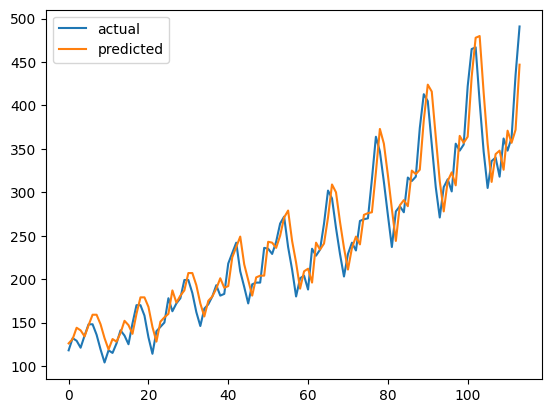

In [14]:
plt.plot(actual,label='actual') # blue
plt.plot(pred,label='predicted') # orange
plt.legend()
plt.show()

The correspondence is incredible given the simplicity of the model.

A lag is apparent, as orange follow blue.
Orange is always greater than blue when blue is decreasing,
and less than blue when blue is increasing. 

Why the lag?
I don't think it is a drawing artifact.

## Links
LSTM window method, Stateful LSTM, [link](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

Google AI blog, BERT and other Transformers [link](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

Counting the parameters in LSTM [link](https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network)